# Pitch Shifting of Sound Data
Sung Hoon Yang **|** shy256
![expected_phase](https://raw.githubusercontent.com/sunghoonyang/gallery-in-jupyter/master/spring19/math_tools_for_ds/img/expected_phase.png)
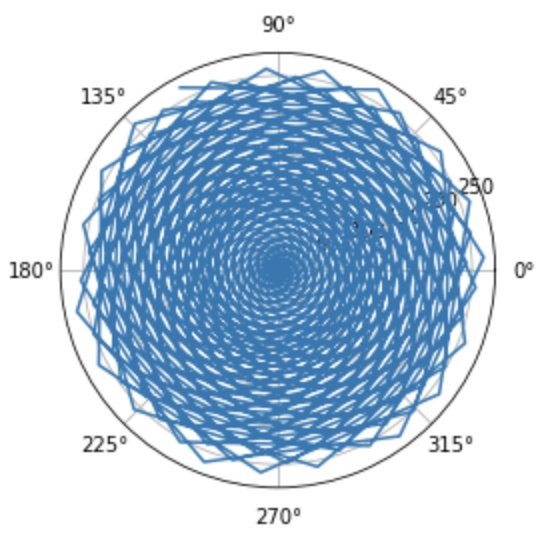

<a id='fig1'></a>

$$
\textit{Polar axes visualization of expected phase}
$$

<a id='introduction'></a>
## Introduction

We begin by recalling the definition of phase. In frequency domain, a sound wave is interpreted as the magnitudes and phases of the frequencies. Given DFT of $\vec{x}$, $\hat{x}$, the magnitude of the frequency at index $k$ is $|\hat{x}[k]|$, and phase is the polar angle $\phi(𝑥̂ [𝑘]):=\angle(𝑥̂ [𝑘])$. In time domain, frequency is rate of change of phase. Phase shift quantifies the change in phase, and is given as:
$$
\begin{align}
    \triangle \phi &= \int w(t)dt \\
    \triangle \phi &\approx w(t)\triangle t \quad \text{If } t \to 0, \\
    \therefore w(t) &\approx \frac{\triangle \phi}{\triangle t} \quad (1) \quad \text{In continuous case}\\
\text{It follows that in discrete case}, \\
w[k]_i &= \frac{(\phi_a[k])_{i} - (\phi_a[k])_{i-1}}{\triangle t_a} \\
\end{align}
$$

Since strides of analysis and synthesis are both very short time periods, the linear approximation at (1) is used to impute the phase at synthesis.

**Phase Vocode (PV)** is a vocoder that scales both frequency and time domains of a signal by using the phase information. We study study its function *pitch shifting* by understanding and solving PV's Horizontal and Vertical Phase Coherence Problem. Pitch shifting is a technique to change the pitch of the sound data. The naive approach is time-scaling. The length of data, which corresponds to the number of samples with respect to the sampling rate, is indicative of the length of time. Suppose the sound data is played at the manipulated rate, which is the original rate scaled by $\alpha$ . 

The effect of time stretching in frequency domain is explained in **Theorem 2.7** of *Signal Representation* Notes. Applying the theorem, we get the following results.

$$
\begin{align}
\text{given that} \quad  \hat{x}[k] &= <\vec{x}, \vec{\phi}_{k}> \\
\hat{y}[k] &= \frac{1}{\alpha} <\vec{x}, \vec{\phi}_{k/\alpha}> \quad \text{where $y(t)=x(\alpha t)$}\\
\therefore \hat{y}[\alpha k] &= \frac{1}{\alpha} <\vec{x}, \vec{\phi}_{\frac{\alpha k}{\alpha}}>\\
&= \frac{1}{\alpha} <\vec{x}, \vec{\phi}_{k}> \quad (2)
\end{align}
$$

The result in words is that the magnitude of $\hat{x}[k]$, the $k^{th}$ Discrete Fourier Transform (DFT) of $x(t)$ will correspond to that of $\hat{y}[\alpha k]$ scaled by $\frac{1}{\alpha}$, where $\alpha$ is the time stretching scaler. Because $\vec{y}$ is a stretched or shrunk version of $\vec{x}$, the sinusoid $\phi_k$ in computation of $\hat{y}[\alpha k]$ naturally corresponds to a frequency that is now scaled by factor of $\alpha$. If $\alpha \gt 1$, $y(t)$ is the same as $x(t)$ time-shrunk by the factor of $\alpha$. On the contrary, $\alpha \lt 1$, is time-stretching. Stretching in Time results in the shrinking in magnitude axis, and stretching in frequency axis. **Fig 1** demonstrates it.

![time_stretching](https://raw.githubusercontent.com/sunghoonyang/gallery-in-jupyter/master/spring19/math_tools_for_ds/img/time_stretching.png)

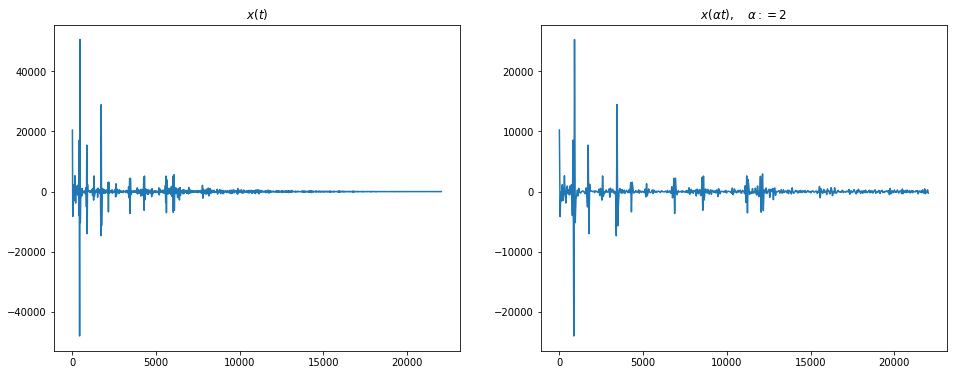

<a id='fig1'></a>

$$
\textbf{Fig 1: }\text{$x(t)$ and time stretched $x(\alpha t)$}
$$

This presents a problem that time domain is inversely affected by the change of frequency $\alpha$. We want to create a phase vocoder that may fix time-dimension constant while it changes frequency. 

## Operations

At each frame, PV iterates three operations: analysis, processing, and synthesis. Analysis consists of computing the Short Time Fourier Transform of data by computing first FFT of data and convolving it with an appropriate window, for example hanning window. This information is used for computing the change in phase from the previous frame. At processing, PV imputes the synthesized phase values from DFT, and applies phase-locking to identify local peaks and their region of influence to promote vertical coherence. At synthesis, Inverse FFT computes the amplitude-time data from the synthesized DFT. If the purpose is stretching the operation ends. If the purpose is pitch-tuning, the synthesized data is stretched or shrunk to achieve the desired pitch and the original length. Below is chronological details of the operations.
    
The localized DFT from each window is indexed to give discretized snapshots of changes in DFT over time. Since this can cause spectral leakage (as visually demonstrated in **Fig 2** of *Signal Representation* Notes) that gives rise to undesired artifacts. Spectral Leakage can be visualized by plotting the expected phase change versus the actual phase change. 

Expected phase change of each bin is simply:

$$
\begin{align}
&\frac{\triangle \phi_{expected}[k]_i}{\triangle t} = w[k]_i, \quad \text{$w$ is DFT of sampled window}\\
\end{align}
$$
Since $\triangle t$ is the stride size, replace it with the stride. For example, to compute the expected phase change of an analysis step:
$$\therefore \triangle \phi_{expected}[k]_i = w[k]_i \times S_{analysis} \quad (3)$$

![spectral_leakage](https://raw.githubusercontent.com/sunghoonyang/gallery-in-jupyter/master/spring19/math_tools_for_ds/img/spectral_leakage.png)
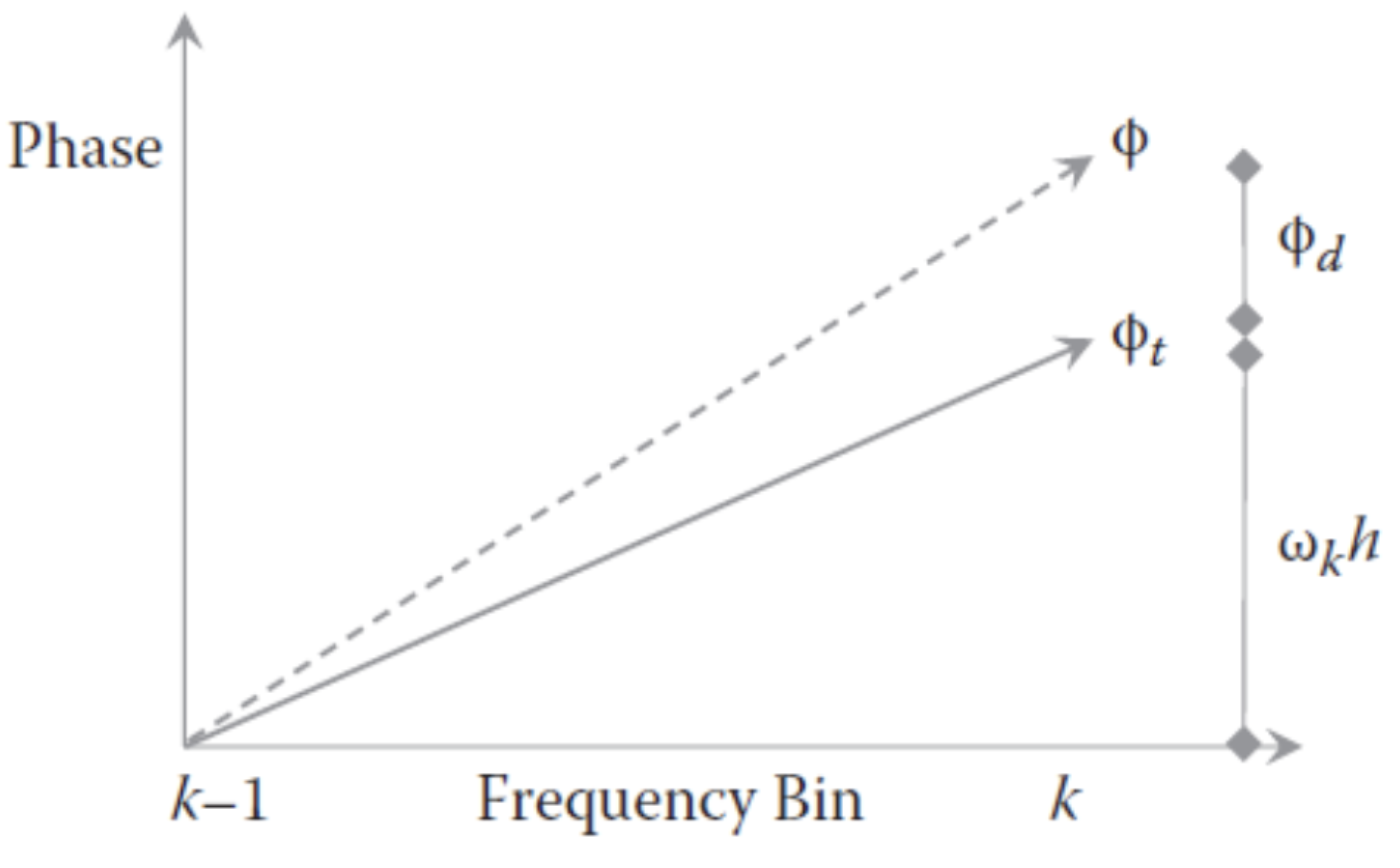

<a id='fig1'></a>

$$
\textbf{Fig 2: }\text{expected phase change $\triangle \phi_{expected}$ vs. phase change at analysis $\triangle \phi_{analysis}$} \quad (\text{Haoyu987/phasevocoder})
$$

Phase information of DFT of sample must be corrected for the output sound data to make sense, with respect to both axes: time and frequency. Horizontal phase coherence with respect to time is enforced by [**Phase Correction**](#phase_correction), while vertical phase coherence with respect to frequency is enforced by [**Phase Locking**](#phase_locking). Finally PV performs [**Time Scaling**](#time_scaling) by choosing the strides of synthesis and analysis to be ratio of the scaling factor, $\alpha$. Choosing strides with ratio $\alpha$ is equivalent to elongating the output array with the longer stride by the same ratio, and is shown in the following secion.


<a id='phase_correction'></a>
### Phase Correction

The magnitude of DFT coefficients signifies the amount of energy in this frequency. Since the magnitudes are naturally mapped to the scaled frequency as per (1), no manipulation of magnitude is necessary. Let us examine how to correctly impute the new phase for synthetic output sound.




$$
\begin{align}
\text{Compute Phase Deviation:} \\
\triangle \phi[k]_i &= (\phi_a[k])_{i} - (\phi_a[k])_{i-1} - \phi_{bin}[k]_i \\
\text{Compute Frequency Deviation:} \\
\triangle w[k]_i &= \frac{\triangle \phi[k]_i}{\triangle t_{a}} \\
\text{Take the mod 2$\pi$ of $\triangle w[k]_i$} \\
\text{to wrap it around the polar axes }, \\
\triangle w_{wrapped}[k]_i &= \big[ \triangle w[k]_i + \pi \mod 2\pi\big] -\pi \\
\text{Impute the true frequency as the expected }\\
\text{frequency of the bin plus the delta of phase}, \\
w_{true}[k]_i &= \triangle w_{wrapped}[k]_i + w_{bin}[k]_i \\
\text{Finally, we impute the phase value at step $i$ as below.} \\
\text{Since, }w_{true}[k]_i &= \frac{(\phi_s[k])_{i} - (\phi_s[k])_{i-1}}{\triangle t_s} \\
\therefore (\phi_s[k])_{i} &= (\phi_s[k])_{i-1} + w_{true}[k]_i \times \triangle t_s \quad (4)\\
\end{align}
$$




*Horizontal phase coherence* is acheived at (4) as PV imputes the phase at $i^{th}$ frame by computing rotation using the synthesis time step size.

## Phase Locking

Vertical phase coherence is compromised when leakage happens when the frequencies in the frame do not have a corresponding bin, and its energy is leaked to the neighboring bins. Manipulating the phase information to account for the leakage is necessary, but may incur *phasiness* of the sound, if done incorrectly, where two sinusoids with different phases will crossfade. The idea behind phase locking is that when the translation to synthesis is computed, the peaks of localized spectra is translated to the arbitrary desired in such a way that the output spectra should resember the input. Mathematically, the idea can be expressed that the phase difference between the peak and the frequency bins are preserved in both analysis and synthesis.
$$
\begin{align}
\phi_s[k_{peak}]  - \phi_s[k] &= \phi_a[k_{peak}]  - \phi_a[k] \quad \text{rearranging,} \\ 
\phi_s[k]  - \phi_a[k] &= \phi_s[k_p]  - \phi_a[k_p]  \quad \text{subtraction is equivalent to multiplying by the phase difference,} \\ 
\phi_s[k]  &= e^{
    \Big(
        i  (\phi_s[k_p]  - \phi_a[k_p])
    \Big)
} \times \phi_a[k] \quad (5)
\end{align}
$$
This will mitigate the suboptimal computation of phase change, because it at least preserves the shape of spectra. There are alternatives suggested to this method due to its problems. For example, this algorithm does not discriminate peaks from sinusoids to those incurred by the lobes that are windowing artifacts and known to be problematic for processing percussive sounds, but acceptable in practice for certain types of sound data.

<a id='time_scaling'></a>
### Time-Scaling

Because we are using STFT, we may manipulate the size of stride in writing the result of analysis, which effectively stretches or shrinks the output data. This process may be thought of as applying FFT to the windowed sample from input data with a stride of $S_{analysis}$, and writing to the output array with window size of $S_{synthesis}$, where $S_{analysis}=\frac{S_{synthesis}}{\alpha}$. 

$
\begin{align}
\text{given } S_{analysis}=\frac{S_{synthesis}}{\alpha} \text{ and $W$ the window size}, \\
\dim(\textit{synthesis}) &= \frac{N_{output}-W}{S_{synthesis}} + 1 \\
\dim(\textit{analysis}) &= \frac{N_{input}-W}{S_{analysis}} + 1 = \alpha\frac{N_{input}-W}{S_{synthesis}} + 1 \\
\text{Since we are writing each window's sample to the synthesis array,}& \\
\dim(\textit{analysis})= \alpha\frac{N_{input}-W}{S_{synthesis}} + 1 &= \dim(\textit{synthesis}) = \frac{N_{output}-W}{S_{synthesis}} + 1 \\
\therefore N_{output} &\approx \alpha N_{input} \quad \text{If N is large} \quad (6)
\end{align}
$

Suppose $\alpha > 1$, then $N_{input}$ is stretched by factor of $\alpha$, returning $N_{output}$. The converse is true for time-shrinking. The output array can then be shrunk by $\alpha$ to get the desired sound signal of length $N_{input}$ and frequency of $\alpha \mathcal{w}_{input}$. 


<a id='resampling'></a>
### Resampling

If the task assigned to PV was time-stretching. The task is complete. However, if the objective is pitch-tuning, the last step is the stretching or shrinking, as already mentioned as naive approach in the [**Introduction**](#introduction). Since $N_{output} \approx \alpha N_{input}$, we are guaranteed to get the original data length back. Below is the computation:

$$
\text{S is the input sequence of length }\alpha \text{ k, and output O has a length of k.}
\\
\begin{align}
    &\text{set } A_{t} :&= \text{S}[\lfloor \alpha k \rfloor ] \\
    &\text{set } A_{t+1} :&= \text{S}[\lfloor \alpha k \rfloor +1] \\
    &\text{set } \theta := \alpha k - \lfloor \alpha k \rfloor 
\end{align}
\\
\\
\theta \text{ essentially is how much energy from two contiguous amplitudes to reflect to this output frames.}  \\
    \therefore O[k] = (1-\theta)A + \theta A_{t+1}  \quad \forall k \quad (7)
$$


## Discussion

The project examined the major operations that take place in PV. Input data is iteratively processed with respect to the convolutional window size. Local data at each frame projected to frequency domain using FFT. Phase correction is applied to compute the phase information at output data for the corresponding frame, achieving horizontal phase coherence. Vertical coherence is achieved when the resulting phase information undergoes phase locking process, where analysis and synthesis phases are locked by computing the frequency peaks, and translating the peaks from analysis to synthesis data. Finally, the synthesized data is time-stretched or -shrunk by the desired factor of $\alpha$. If the objective is pitch-tuning, the synthesized data will undergo resampling by the same factor, resulting in the output data with tuned pitch, but with the same length.

## Bibliography

Amara, N. S. M., & Kumar, P. K. Implementation of Pitch Shifter using Phase Vocoder Algorithm on Artix-7 FPGA.

Průša, Z., & Holighaus, N. (2017, August). Phase vocoder done right. In 2017 25th European Signal Processing Conference (EUSIPCO) (pp. 976-980). IEEE.

Portnoff, M. "Implementation of the digital phase vocoder using the fast Fourier transform." IEEE Transactions on Acoustics, Speech, and Signal Processing 24.3 (1976): 243-248.

Laroche, J., & Dolson, M. (1999). New phase-vocoder techniques for pitch-shifting, harmonizing and other exotic effects. In Proceedings of the 1999 IEEE Workshop on Applications of Signal Processing to Audio and Acoustics. WASPAA'99 (Cat. No. 99TH8452) (pp. 91-94). IEEE.

Haoyu987. (2018, August 01). Haoyu987/phasevocoder. Retrieved from https://github.com/haoyu987/phasevocoder
